# 1、SE Net模块

论文《Squeeze-and-Excitation Networks》

### 1、作用

SENet通过引入一个新的结构单元——“Squeeze-and-Excitation”（SE）块——来增强卷积神经网络的代表能力。是提高卷积神经网络（CNN）的表征能力，通过显式地建模卷积特征通道之间的依赖关系，从而在几乎不增加计算成本的情况下显著提升网络性能。SE模块由两个主要操作组成：压缩（Squeeze）和激励（Excitation）



### 2、**机制**

**1、压缩操作：**

SE模块首先通过全局平均池化操作对输入特征图的空间维度（高度H和宽度W）进行聚合，为每个通道生成一个通道描述符。这一步有效地将全局空间信息压缩成一个通道向量，捕获了通道特征响应的全局分布。这一全局信息对于接下来的重新校准过程至关重要。

**2、激励操作：**

在压缩步骤之后，应用一个激励机制，该机制本质上是由两个全连接（FC）层和一个非线性激活函数（通常是sigmoid）组成的自门控机制。第一个FC层降低了通道描述符的维度，应用ReLU非线性激活，随后第二个FC层将其投影回原始通道维度。这个过程建模了通道间的非线性交互，并产生了一组通道权重。

**3、特征重新校准：**

激励操作的输出用于重新校准原始输入特征图。输入特征图的每个通道都由激励输出中对应的标量进行缩放。这一步骤有选择地强调信息丰富的特征，同时抑制不太有用的特征，使模型能够专注于任务中最相关的特征。



### 3、**独特优势**

1、**通道间依赖的显式建模**：

SE Net的核心贡献是通过SE块显式建模通道间的依赖关系，有效地提升了网络对不同通道特征重要性的适应性和敏感性。这种方法允许网络学会动态地调整各个通道的特征响应，以增强有用的特征并抑制不那么重要的特征。

2、**轻量级且高效**：

尽管SE块为网络引入了额外的计算，但其设计非常高效，额外的参数量和计算量相对较小。这意味着SENet可以在几乎不影响模型大小和推理速度的情况下，显著提升模型性能。

3、**模块化和灵活性**：

SE块可以视为一个模块，轻松插入到现有CNN架构中的任何位置，包括ResNet、Inception和VGG等流行模型。这种模块化设计提供了极大的灵活性，使得SENet可以广泛应用于各种架构和任务中，无需对原始网络架构进行大幅度修改。

4、**跨任务和跨数据集的泛化能力**：

SENet在多个基准数据集上展现出了优异的性能，包括图像分类、目标检测和语义分割等多个视觉任务。这表明SE块不仅能提升特定任务的性能，还具有良好的泛化能力，能够跨任务和跨数据集提升模型的效果。

5、**增强的特征表征能力**：

通过调整通道特征的重要性，SENet能够更有效地利用模型的特征表征能力。这种增强的表征能力使得模型能够在更细粒度上理解图像内容，从而提高决策的准确性和鲁棒性。

## 将SE模块与resnet混合，支持 ： "resnet18_SE" "resnet34_SE" "resnet50_SE"  "resnet101_SE"  "resnet152_SE"               

In [1]:
import os
import torch
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from pixelmed_calc.medical_imaging.modelstore import get_model_from_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model=get_model_from_name['resnet50_SE'](num_classes = 2, pretrained = False,in_channels=3).to(device)
#model.load_state_dict(torch.load(r'd:\pixelmedAI\function_pm\note2-深度学习分类\results\latest_model.pth'))

In [2]:
from pixelmed_calc.medical_imaging.DLtools.process2d import load_data_from_csv,get_file_and_labels,get_transforms,CustomImageDataset,train_and_validate
import torch
from monai.data import DataLoader
train_base_path = r'D:\pixelmedAI\function_pm\pm_data\MR_jpg\images'
val_base_path = r'D:\pixelmedAI\function_pm\pm_data\MR_jpg\images'
input_size=256
# CSV文件路径
csv_path = r'D:\pixelmedAI\function_pm\pm_data\MR_jpg\group.csv'
tfs =get_transforms(input_size)


# 读取所有数据
file_names, labels, groups = load_data_from_csv(csv_path)

# 获取训练数据和标签（可以设置 base_path 为 None 或实际路径）
file_train, train_labels = get_file_and_labels(file_names, labels, groups, 'train', train_base_path)

# 获取验证数据和标签（可以设置 base_path 为 None 或实际路径）
file_val, val_labels = get_file_and_labels(file_names, labels, groups, 'test', val_base_path)


# 假设你已经定义了 ImageDataset 和 train_transforms, val_transforms
train_ds = CustomImageDataset(image_files=file_train, labels=train_labels, transform=tfs)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

val_ds = CustomImageDataset(image_files=file_val, labels=val_labels, transform=tfs)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())



In [3]:
train_and_validate(model, train_loader, val_loader, learning_rate=1e-4, epochs=10)

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


Epoch 1/10, Training Loss: 0.7936, Training ACC: 0.4000, Validation Loss: 0.7188, Validation ACC: 0.4286
当前best_epoch 1
Epoch 2/10, Training Loss: 0.6817, Training ACC: 0.6000, Validation Loss: 0.7712, Validation ACC: 0.4286
Epoch 3/10, Training Loss: 0.8124, Training ACC: 0.6000, Validation Loss: 0.7601, Validation ACC: 0.4286
Epoch 4/10, Training Loss: 0.6674, Training ACC: 0.7000, Validation Loss: 0.7136, Validation ACC: 0.4286
Epoch 5/10, Training Loss: 0.8065, Training ACC: 0.5000, Validation Loss: 0.7051, Validation ACC: 0.4286
Epoch 6/10, Training Loss: 0.6873, Training ACC: 0.5000, Validation Loss: 0.7444, Validation ACC: 0.4286
Epoch 7/10, Training Loss: 0.5899, Training ACC: 0.6000, Validation Loss: 0.8273, Validation ACC: 0.4286
Epoch 8/10, Training Loss: 1.0221, Training ACC: 0.3000, Validation Loss: 1.0283, Validation ACC: 0.4286
Epoch 9/10, Training Loss: 0.6837, Training ACC: 0.5000, Validation Loss: 1.1109, Validation ACC: 0.4286
Epoch 10/10, Training Loss: 0.6161, Trai

In [6]:
model=get_model_from_name['resnet50_SE'](num_classes = 2, pretrained = False,in_channels=3).to(device)
model.load_state_dict(torch.load(r'd:\pixelmedAI\function_pm\note2-深度学习分类\results\latest_model.pth'))
for name, _ in model.named_modules(): print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

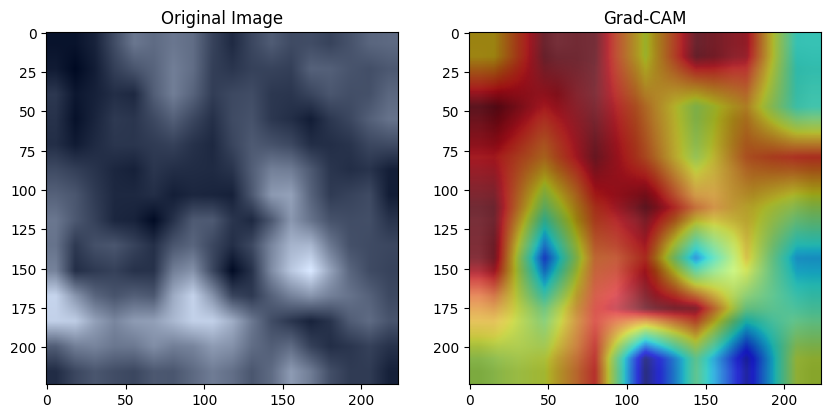

In [8]:
from pixelmed_calc.medical_imaging.DLtools.process2d import load_preprocess_image,visualize_gradcam
import torch
from PIL import Image
model = get_model_from_name['resnet50_SE'](num_classes=2, pretrained=False, in_channels=3).to(device)
model.load_state_dict(torch.load(r'd:\pixelmedAI\function_pm\note2-深度学习分类\results\latest_model.pth'))
img_path = r'd:\pixelmedAI\function_pm\pm_data\MR_jpg\images\data4.jpg'  # 替换为实际 PNG 图像路径
image = Image.open(img_path).convert('RGB')
img_tensor=load_preprocess_image(img_path,224)
visualize_gradcam(model, img_tensor)